In [1]:
import warnings
warnings.filterwarnings('ignore')

# Activity and Sleep
In this notebook we focus on the Fitbit activity data as a means to unearth some questions about the sleep metrics. 

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

from scipy import stats
from scipy.stats import linregress

# Table of Contents
1. [Data Import](#data_import)
    1. [Target Data: Fitbit Sleep](#targets)
    2. [Feature Data: Fitbit Activity](#features)
2. [Pre-Processing](#preprocessing)
    1. [Target Data](#target_data)
        1. Summary
        1. Scaling
    2. [Feature Data](#feature_data)
3. [Analyzing Relationships](#analysis)

In [3]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2

<a id='data_import'></a>

# Data Import
Data are simply imported from the Fitbit daily dataset and Fitbit sleep summary dataset - both of each include data summarized on a daily basis.

<a id='targets'></a>

## Target Data: Fitbit Sleep
We can start by importing the labels dataset: Fitbit sleep metrics.

In [4]:
targets = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time"])
targets = targets[targets["efficiency"] > 75]
targets.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,redcap,beacon,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb
count,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3231.000000,1707.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000
mean,3.711799,77.916814,28.657817,243.523009,9.643953,87.778171,30.979056,64.664012,93.079646,47.404519,21.349151,32.369617,0.311752,321.439823,0.277618,7.898033
std,1.467000,26.237631,8.771400,55.974897,4.400275,31.088178,9.555100,20.084407,3.407527,23.770786,11.929696,9.454834,0.148456,63.679114,0.095962,1.530750
min,0.000000,0.000000,4.000000,51.000000,0.000000,0.000000,5.000000,14.000000,77.000000,0.000000,1.000000,5.000000,0.000000,116.000000,0.000000,3.033333
25%,3.000000,60.000000,23.000000,208.000000,6.000000,67.000000,25.000000,51.000000,91.000000,29.000000,13.000000,26.000000,0.200000,285.000000,0.213607,7.050000
50%,4.000000,78.000000,28.000000,242.000000,9.000000,88.000000,31.000000,64.000000,93.000000,47.000000,21.000000,32.000000,0.289474,324.000000,0.276219,7.966667
75%,5.000000,95.000000,34.000000,278.000000,12.000000,108.000000,37.000000,76.750000,96.000000,66.000000,29.000000,39.000000,0.392857,360.000000,0.342181,8.850000
max,10.000000,177.000000,64.000000,598.000000,26.000000,219.000000,75.000000,200.000000,100.000000,90.000000,46.000000,69.000000,1.142857,775.000000,0.778409,17.683333


<a id='features'></a>

## Feature Data: Fitbit Activity
Should contain a similar number of observations as the Fitbit sleep data since both are measured by the Fitbit.

In [5]:
features_activity = pd.read_csv("../data/processed/fitbit_fitbit-daily_activity_and_sleep-ux_s20.csv",parse_dates=["date","start_date","end_date","start_time","end_time"])
# cleaning
features_activity.drop(["water_logged","food_calories_logged","fat","bmr"],axis="columns",inplace=True)
features_activity = features_activity[features_activity["efficiency"] > 75]
features_activity.describe()

,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,redcap,beacon,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb,calories,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,bmi,weight
count,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3137.000000,1637.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000,3296.000000
mean,3.714502,77.846481,28.666869,243.347391,9.650485,87.669296,31.002124,64.841323,93.054005,47.628626,21.244349,32.381371,0.311741,321.193871,0.277488,7.895075,2163.817051,7382.840413,3.228392,738.475121,204.423544,17.228155,20.696299,901.559466,22.412794,135.174308
std,1.469193,26.211283,8.758576,55.869980,4.413091,31.199099,9.561382,20.084510,3.408389,23.854405,11.838364,9.441387,0.148709,63.581430,0.096326,1.530835,547.342765,5244.281378,2.423900,190.636875,97.520487,26.296964,30.571615,530.730664,3.055731,23.802070
min,0.000000,0.000000,4.000000,51.000000,0.000000,0.000000,5.000000,14.000000,77.000000,0.000000,1.000000,5.000000,0.000000,116.000000,0.000000,3.033333,1049.000000,4.000000,0.001616,0.000000,0.000000,0.000000,0.000000,0.000000,17.032816,96.990000
25%,3.000000,60.000000,23.000000,208.000000,6.000000,67.000000,25.000000,51.000000,91.000000,29.000000,13.000000,26.000000,0.200000,285.000000,0.213375,7.050000,1789.000000,3476.500000,1.448997,631.000000,140.000000,0.000000,0.000000,527.000000,20.376562,117.000000
50%,4.000000,78.000000,28.000000,242.000000,9.000000,88.000000,31.000000,64.000000,93.000000,47.000000,21.000000,32.000000,0.289474,324.000000,0.276094,7.966667,2063.000000,6227.000000,2.650720,722.000000,190.000000,8.000000,6.000000,805.000000,21.674603,129.990000
75%,5.000000,95.000000,34.000000,278.000000,12.000000,108.000000,37.000000,77.000000,96.000000,66.000000,29.000000,39.000000,0.393128,360.000000,0.341659,8.833333,2434.000000,10046.250000,4.435736,812.000000,254.000000,23.000000,33.000000,1162.250000,24.274609,145.000000
max,10.000000,177.000000,64.000000,598.000000,26.000000,219.000000,75.000000,200.000000,100.000000,90.000000,46.000000,69.000000,1.142857,775.000000,0.778409,17.683333,6015.000000,37485.000000,17.323717,1440.000000,636.000000,246.000000,275.000000,4917.000000,37.064701,256.000000


<div class="alert alert-block alert-success">
    
Fitbit activity data have already been merged with sleep data so we can simiply use the `features_activity` dataset for all analysis.
    
</div>

<a id='preprocessing'></a>

# Pre-Processing
The analysis section is outlined as followed:

- [Target Data](#target_data)
- [Feature Data](#feature_data)

Much of this code has been refractured into the `processing` source code and we import that module below so that we can simplify the code presented in this notebook.

In [6]:
from src.processing import process
# defining feature engineering object
pp = process.preprocess()

<a id='target_data'></a>

## Target Data
Since the feature sets are all corroborated against the Fitbit sleep data, there won't be any missing data values so we don't have to worry about filling in any gaps.

The general outline is as follows:

- [Scaling](#scaling)

<a id="scaling"></a>

### Scaling
Data recorded as minutes spent in different stages should be scaled based on the TST for that night since time spent in sleep stages is dependent on the time one is asleep. However this is not scaling in a traditional sense, but more of a _target engineering_.

In [7]:
def add_sleep_percentage(df):
    """Converts and drops minute columns into percentage columns"""
    for column in df.columns:
        if column.endswith("minutes") and column not in ["sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"]:
            variable = column.split("_")[0]
            df[variable+"_percent"] = df[column] / (df["tst_fb"]*60) * 100
            df.drop(column,axis="columns",inplace=True)

    df["rem2nrem_percent"] = df["rem_percent"] / df["nrem_percent"]
    return df

In [8]:
targets_and_features = add_sleep_percentage(features_activity)
targets_and_features.head()

,start_date,end_date,deep_count,light_count,rem_count,wake_count,beiwe,efficiency,end_time,start_time,redcap,beacon,nrem_count,rem2nrem_count,tst_fb,date,timestamp,calories,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,bmi,weight,deep_percent,light_percent,rem_percent,wake_percent,nrem_percent,rem2nrem_percent
0,2020-05-14,2020-05-14,5,20,10,21,hfttkth7,97,2020-05-14 07:13:00,2020-05-14 00:27:00,NaN,NaN,25,0.400000,6.766667,2020-05-13,2020-05-13,2781.0,9207,4.396294,1241,70,118,11,1097.0,23.754,180.0,20.689655,52.463054,20.197044,6.650246,73.152709,0.276094
1,2020-05-14,2020-05-15,4,31,6,33,hfttkth7,87,2020-05-15 08:06:30,2020-05-14 23:53:30,NaN,NaN,35,0.171429,8.216667,2020-05-14,2020-05-14,3727.0,15207,7.261114,614,263,134,23,2234.0,23.754,180.0,19.269777,50.709939,9.533469,20.486815,69.979716,0.136232
2,2020-05-15,2020-05-16,2,17,8,20,hfttkth7,95,2020-05-16 04:57:00,2020-05-15 23:28:00,NaN,NaN,19,0.421053,5.483333,2020-05-15,2020-05-15,3909.0,14556,8.028501,577,205,57,108,2381.0,23.754,180.0,14.285714,57.750760,15.197568,12.765957,72.036474,0.210970
3,2020-05-17,2020-05-17,5,21,11,25,hfttkth7,96,2020-05-17 09:28:30,2020-05-17 02:01:30,NaN,NaN,26,0.423077,7.450000,2020-05-16,2020-05-16,3927.0,18453,8.748670,760,176,24,151,2364.0,23.754,180.0,17.449664,54.138702,18.568233,9.843400,71.588367,0.259375
4,2020-05-18,2020-05-18,5,20,14,28,hfttkth7,92,2020-05-18 07:20:00,2020-05-18 00:24:00,NaN,NaN,25,0.560000,6.933333,2020-05-17,2020-05-17,4180.0,15425,7.973149,605,207,50,131,2652.0,23.754,180.0,23.076923,40.144231,21.153846,15.625000,63.221154,0.334601


<div class="alert alert-block alert-info">
    
We now have a DataFrame, `targets_and_features`, that we can use for the remaining analysis.
    
</div>

<a id="feature_data"></a>

## Feature Data
We can now look more closely at the activity data.

## Summary
First we need to see with the data that we are working with

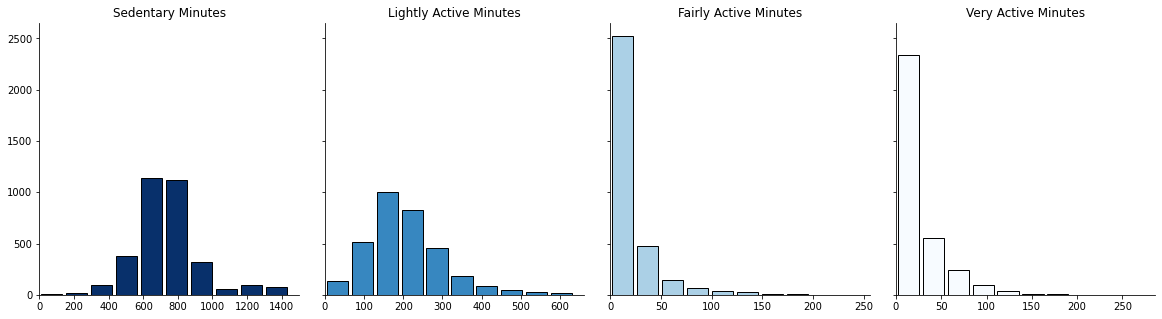

In [9]:
pp.plot_hist(targets_and_features[["sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"]])

<div class="alert alert-block alert-info">
    
Overall we can see that our participants tend to have very low amounts of `fairly_active` and `very_active` minutes.
    
</div>

## Clustering by Activity Level
We can use guidelines developed by the American College of Sports Medicine (ACSM) to determine low versus high activity nights. ACSM states that adults should do:
* Moderate Intensity: 150 - 300 minutes per week, or
* Vigorous: 75 - 150 minutes per week, or
* Combination

Fitbit divides activity level into multiple categories. While the cutoff points are not very clear, they are most likely:
* Sedentary: MET < 1
* Light: MET < 3
* Fairly: MET < 6
* Very: > 6

Regardless, we can try including various components of the activity metrics to see if they change the results.

### Activity by Day
It is easier to look at on a per-day basis so the cutoffs discussed above can be altered:
* Moderate: 21 - 43 minutes per day
* Vigorous: 11 - 21 minutes per day

#### Moderate and Vigorous per Day
We will start with what seems the most straightforward separation: getting enough moderate and vigorous activity per day.

Based on the guidelines, one needs twice as many moderate minutes as vigorous minutes of activity. In order to address the "combination" category, we can multiply the number of vigorous minutes by 2 and add this value to the moderately active minutes which will allow us to compare this value to the moderately active minutes threshold. 

In [10]:
# getting the moderately active minutes based on the discussion above
activity_daily = targets_and_features[[column for column in targets_and_features.columns if column.endswith("minutes") or column.endswith("percent") or column in ["tst_fb","efficiency"]]]
activity_daily["combined_active_minutes"] = activity_daily["fairly_active_minutes"] + activity_daily["very_active_minutes"]*2
# getting columns based on active minutes
activity_daily["fairly_met"] = activity_daily["fairly_active_minutes"] > 21 
activity_daily["very_met"] = activity_daily["very_active_minutes"] > 11
activity_daily["combined_met"] = activity_daily["combined_active_minutes"] > 21
activity_daily.head()

,efficiency,tst_fb,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,deep_percent,light_percent,rem_percent,wake_percent,nrem_percent,rem2nrem_percent,combined_active_minutes,fairly_met,very_met,combined_met
0,97,6.766667,1241,70,118,11,20.689655,52.463054,20.197044,6.650246,73.152709,0.276094,140,True,False,True
1,87,8.216667,614,263,134,23,19.269777,50.709939,9.533469,20.486815,69.979716,0.136232,180,True,True,True
2,95,5.483333,577,205,57,108,14.285714,57.750760,15.197568,12.765957,72.036474,0.210970,273,True,True,True
3,96,7.450000,760,176,24,151,17.449664,54.138702,18.568233,9.843400,71.588367,0.259375,326,True,True,True
4,92,6.933333,605,207,50,131,23.076923,40.144231,21.153846,15.625000,63.221154,0.334601,312,True,True,True


#### Light, Moderate, and Vigorous per Day
We can also include the number of `lightly_active_minutes` participants logged, but again scale this value by a certain factor similar to how we handled `very_active_minutes`. Here we will use a factor of 0.5 to scale the number of `lightly_active_minutes` down.

In [11]:
activity_daily["non_sedentary_active_minutes"] = activity_daily["lightly_active_minutes"]*0.5 + activity_daily["fairly_active_minutes"] + activity_daily["very_active_minutes"]*2
activity_daily["non_sedentary_met"] = activity_daily["non_sedentary_active_minutes"] > 21

#### Summary
We look at the results from parsing out the participants activity on a per day basis

In [12]:
for column in activity_daily.columns:
    if column.endswith("met"):
        temp = activity_daily[activity_daily[column]]
        print(f"{column.split('_met')[0]}: {len(temp)}/{len(activity_daily)}")

fairly: 886/3296
very: 1411/3296
combined: 1778/3296
non_sedentary: 3233/3296


<div class="alert alert-block alert-danger">
    
Including the `lightly_active_minutes` category might not be applicable to include since it seems nearly every day is included.
    
</div>

### Activity by Week
The guidelines are really _per week_ so perhaps we can include a rolling average of 7 days per participant to get at the true guideline.

In [13]:
activity_weekly = targets_and_features.copy()
activity_weekly.drop(["start_date","end_date","timestamp","end_time","start_time","beiwe","beacon"],axis="columns",inplace=True)
activity_weekly.set_index("date",inplace=True)

To pre-process the data we need to:
1. include all days within each participant's date range
2. Create a `moderately_active_minutes` column that is a combination of the `fairly` and `very` active columns from the original dataset
3. Create rolling sums for the `moderately_active_minutes` and `very_active_minutes`
4. Drop any NaNs from the rolling averages and negative values from the reindexing fill

In [14]:
activity_weekly_complete = pd.DataFrame()
# looping through each participant
for pt in activity_weekly["redcap"].unique():
    act_by_pt = activity_weekly[activity_weekly["redcap"] == pt]
    if len(act_by_pt) > 1:
        # getting date range of data and reindexing to include missing days
        dt = pd.date_range(min(act_by_pt.index), max(act_by_pt.index))
        act_by_pt = act_by_pt.reindex(dt, fill_value=0)
        # creating moderate activity columns
        act_by_pt["moderately_active_minutes"] = act_by_pt["fairly_active_minutes"]
        act_by_pt["vigorously_active_minutes"] = act_by_pt["very_active_minutes"]
        act_by_pt["combined_active_minutes"] = act_by_pt["fairly_active_minutes"] + act_by_pt["very_active_minutes"]*2
        # getting rolling averages
        for level in ["combined","moderately","vigorously"]:
            act_by_pt[f"{level}_weekly"] = act_by_pt[f"{level}_active_minutes"].rolling(7,7).sum()
            # backfilling first entries with the mean value
            act_by_pt[f"{level}_weekly"].fillna(value=np.nanmean(act_by_pt[f"{level}_weekly"]))
        # appending to final dataframe
        activity_weekly_complete = activity_weekly_complete.append(act_by_pt)

activity_weekly_complete = activity_weekly_complete[activity_weekly_complete["nrem_percent"] > 0]

With the rolling averages column, we now can include columns to see if the recommendations were met just like before.

In [15]:
levels = ["moderately","combined","vigorously"]
thresholds = [300,300,150]
for level, threshold in zip(levels, thresholds):
    activity_weekly_complete[f"{level}_met"] = activity_weekly_complete[f"{level}_weekly"] >= threshold

<a id="analysis"></a>

# Analyzing Relationships

## Activity and BMI
There should be a generally strong relationship between BMI and active minutes. We confirm that relationship in the following cells.

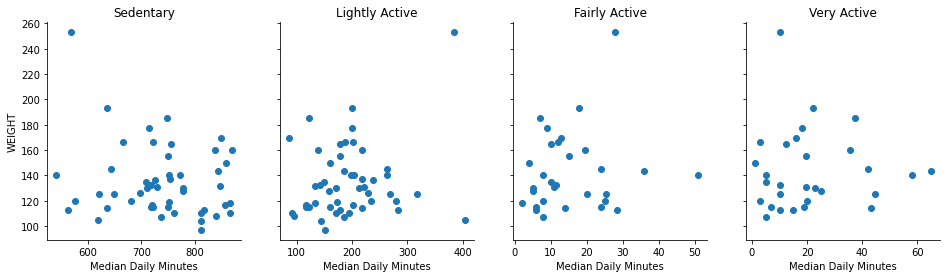

In [16]:
activity_and_bmi = targets_and_features[["sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes","bmi","weight","redcap"]]
mean_activity = activity_and_bmi.groupby(["redcap"]).median()
fig, axes = plt.subplots(1,4,figsize=(16,4),sharey=True)
response = "weight"
levels = ["sedentary_minutes","lightly_active_minutes","fairly_active_minutes","very_active_minutes"]
for ax, level in zip(axes, levels):
    temp = mean_activity[mean_activity[level] > 0]
    ax.scatter(temp[level],temp[response])
    ax.set_xlabel("Median Daily Minutes")
    ax.set_title(level.split("_minutes")[0].replace("_"," ").title())
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
        
axes[0].set_ylabel(response.upper())
        
plt.show()
plt.close()

<div class="alert alert-block alert-danger">
    
No clear relationship exists between a participant's marker of size (`weight` or `BMI`) and activity level.
    
</div>

## Activity and Sleep (Aggregate)
The meat-and-potatoes of our analylsis, we can see if any of the activity categories we developed show clear differences in sleep metrics.

In [17]:
from src.analysis import activity_and_sleep
fitbit_processor = activity_and_sleep.fitbit_sleep(path_to_data="../data")

### Scatter
Perhaps there are patterns in a simple scatter plot.

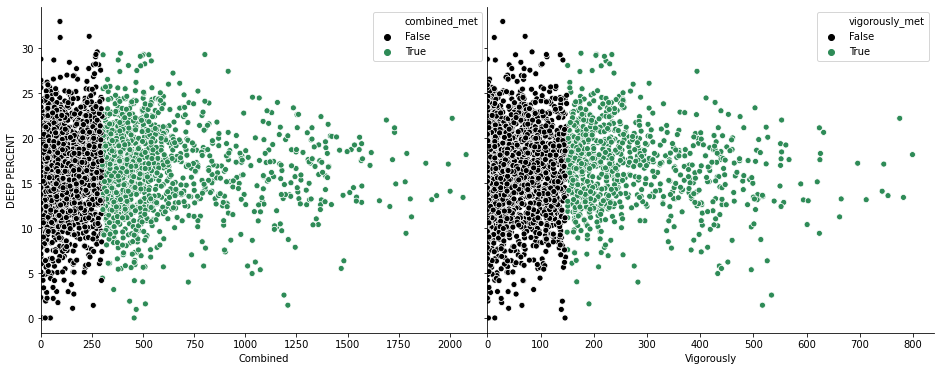

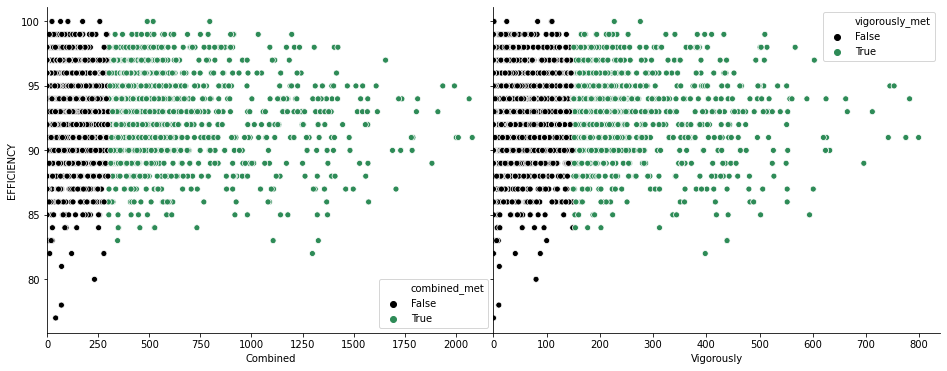

In [18]:
fitbit_processor.plot_scatter(activity_weekly_complete, sleep_metrics=["deep_percent","efficiency"], save=True)

### Violin
Rather than look for relationships within the scatter plots, we can instead see if there are any differences in the distributions of sleep metrics for these categories.

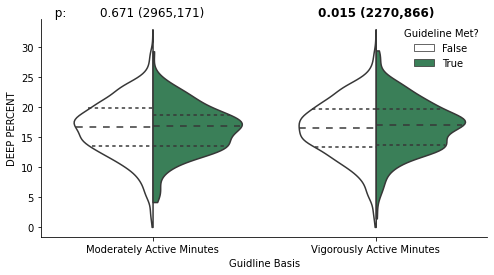

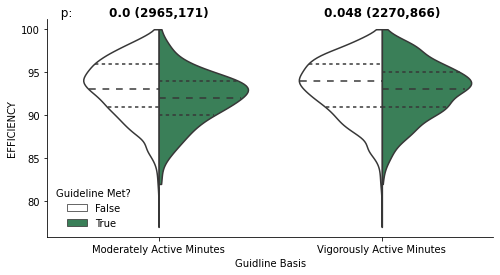

In [19]:
fitbit_processor.plot_violins(activity_weekly_complete, checks=["moderately_met","vigorously_met"],sleep_metrics=["deep_percent","efficiency"], annotate=True, save=True, save_dir="../reports/figures/fitbit_summary")

## Activity and Sleep (Individual)
Perhaps if we look on an individual level, we can get a better sense of the relationship that we should be seeing.

In [20]:
print("Number of Participants:", len(activity_weekly_complete["redcap"].unique()))

Number of Participants: 48


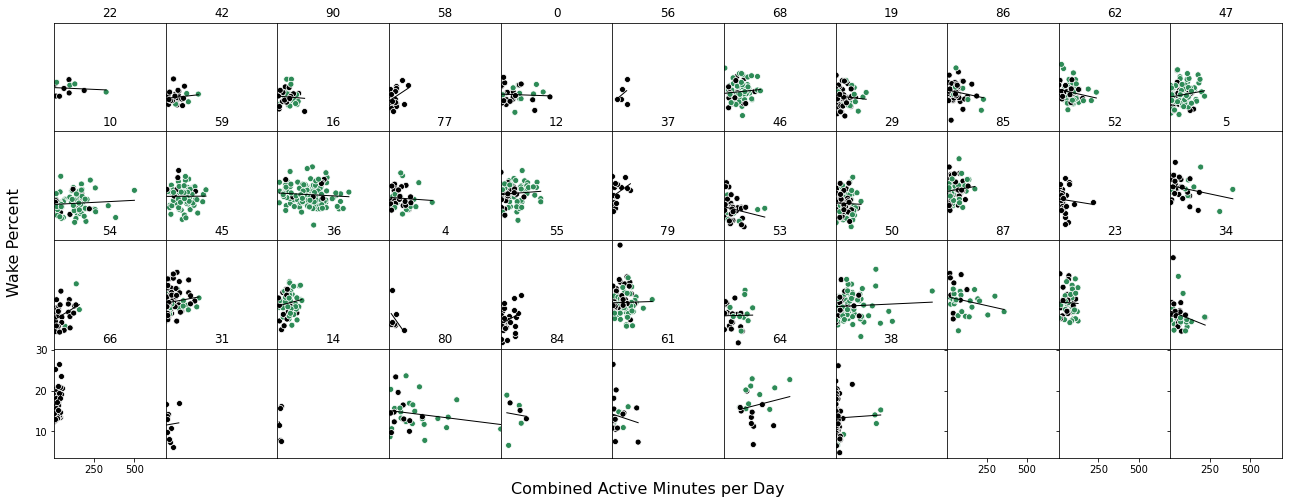

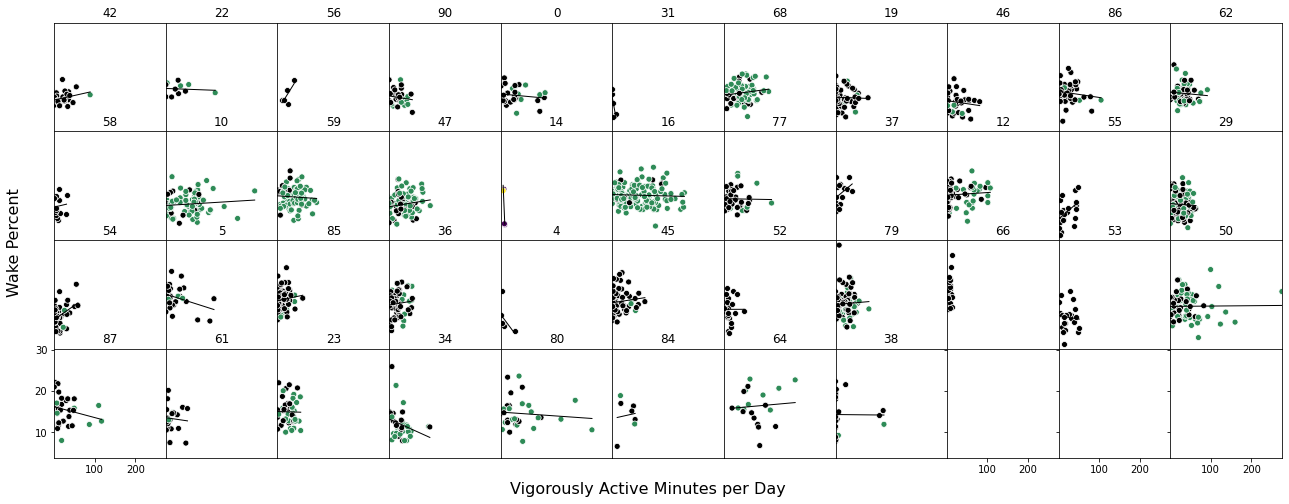

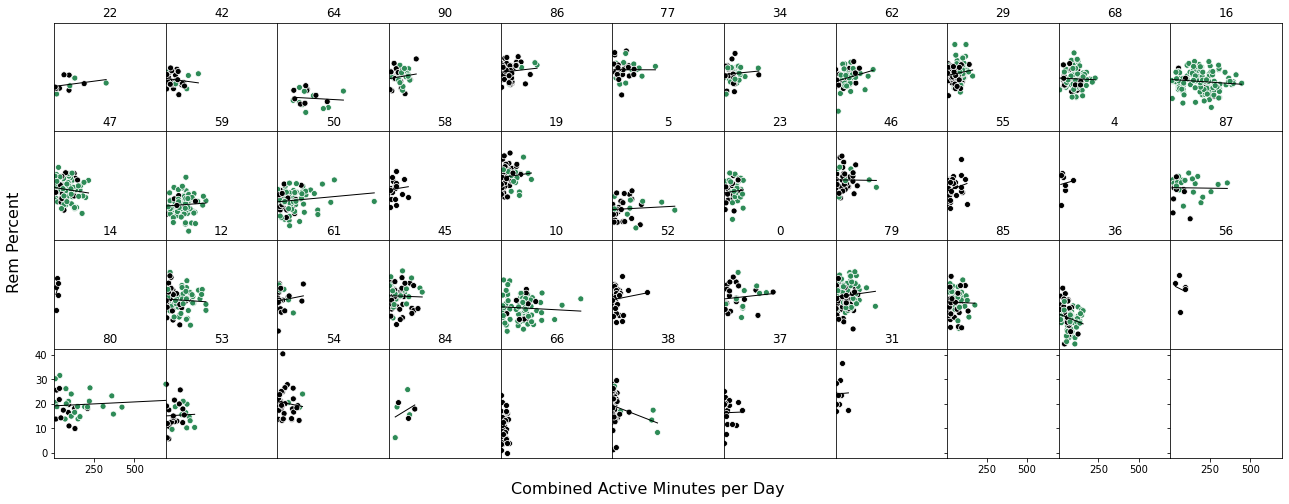

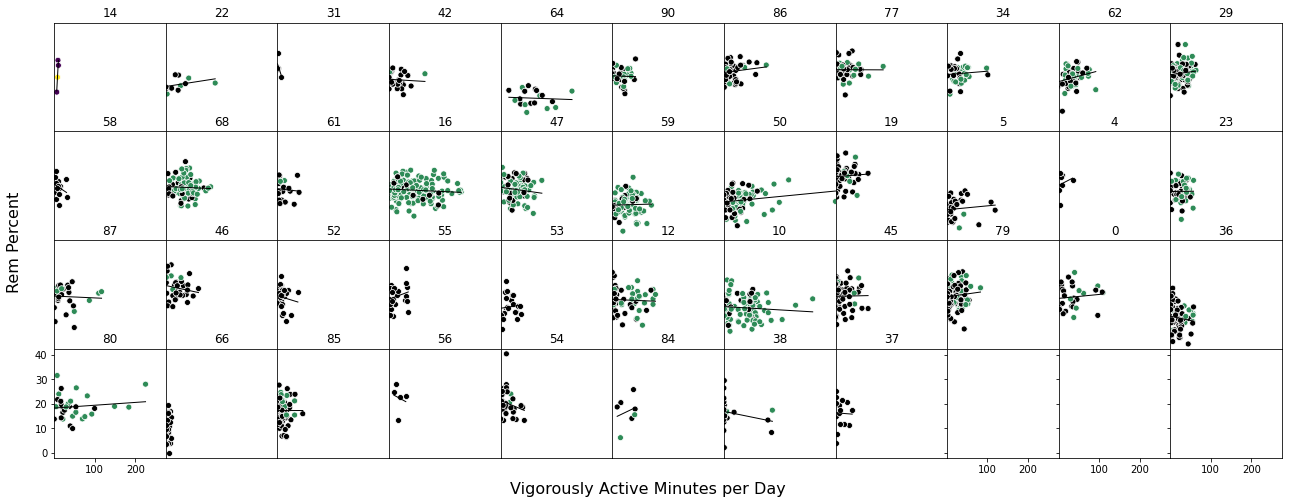

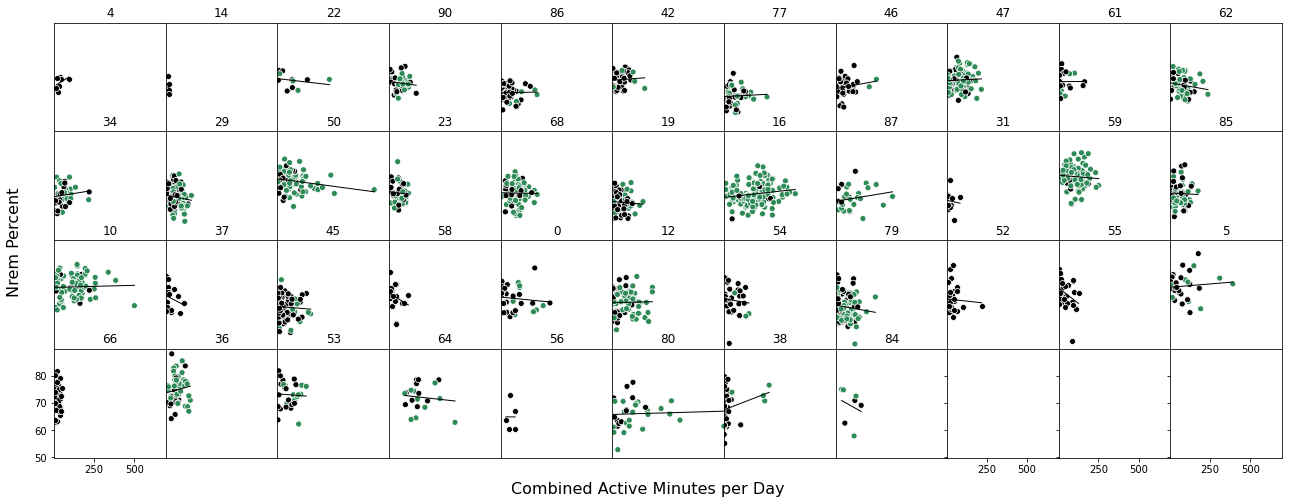

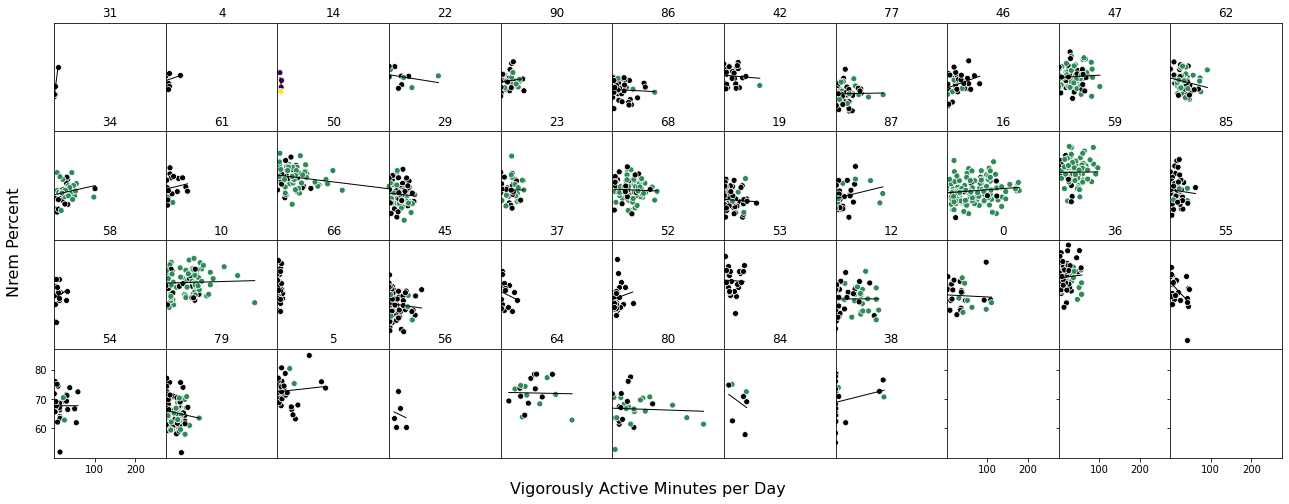

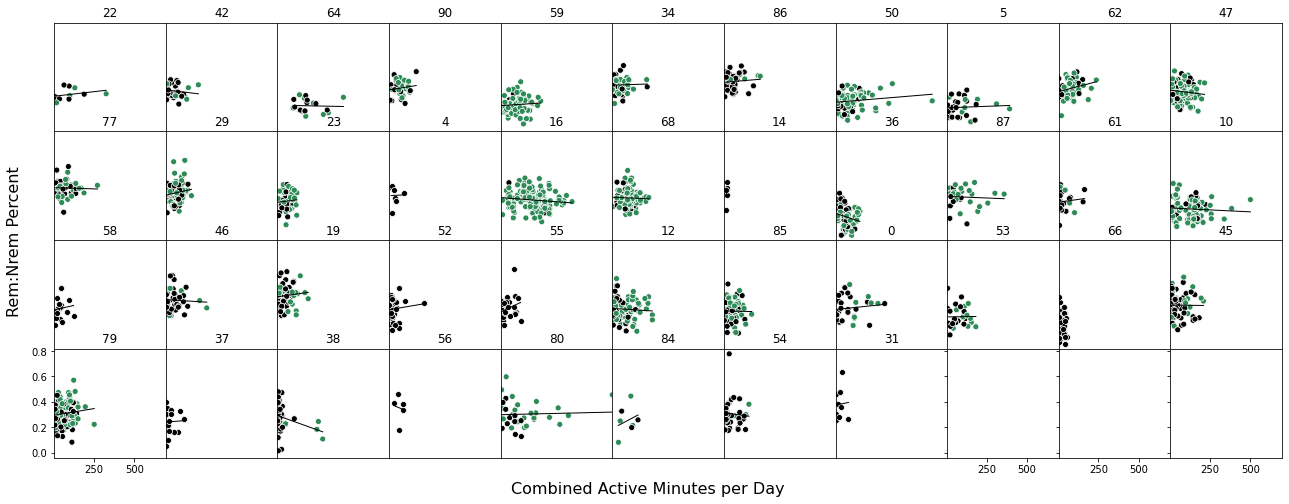

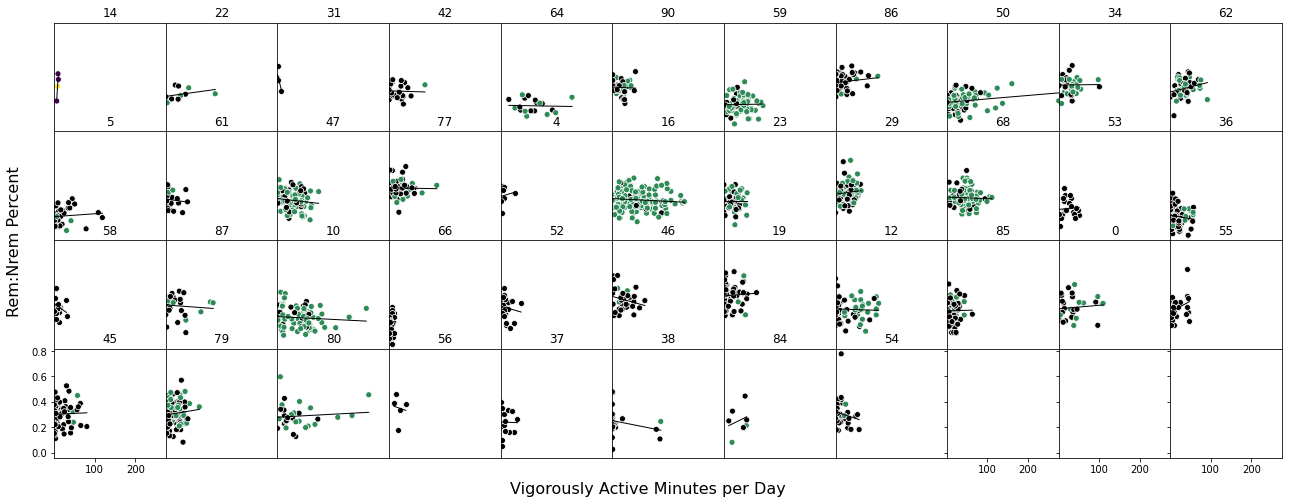

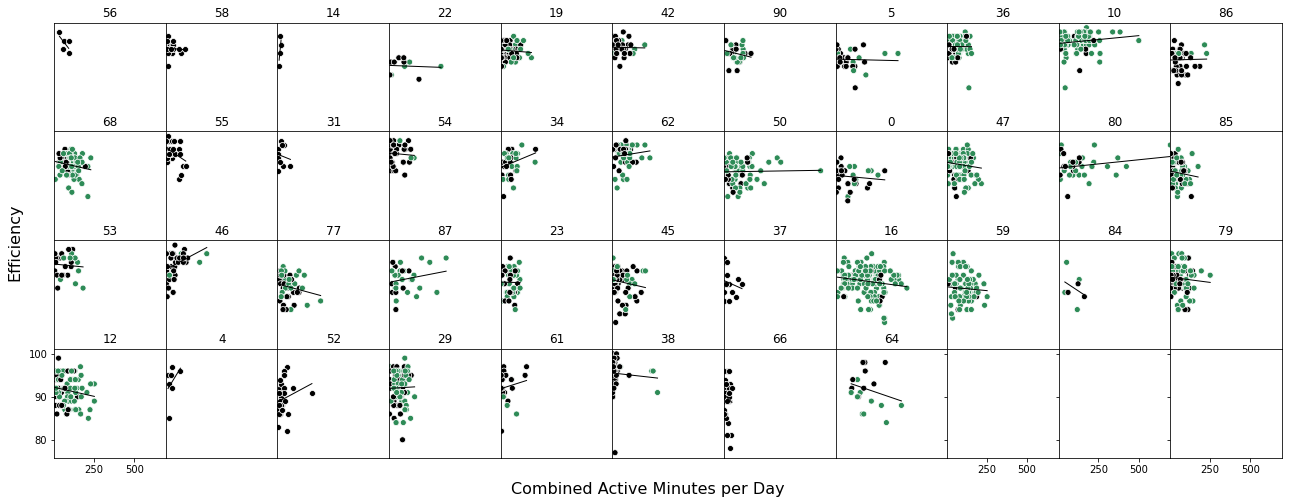

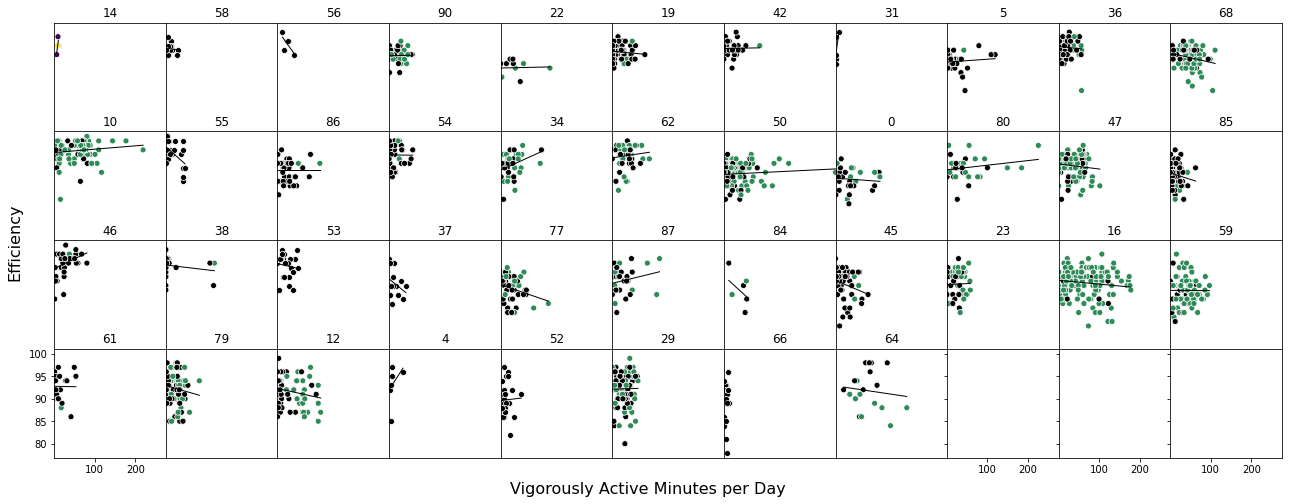

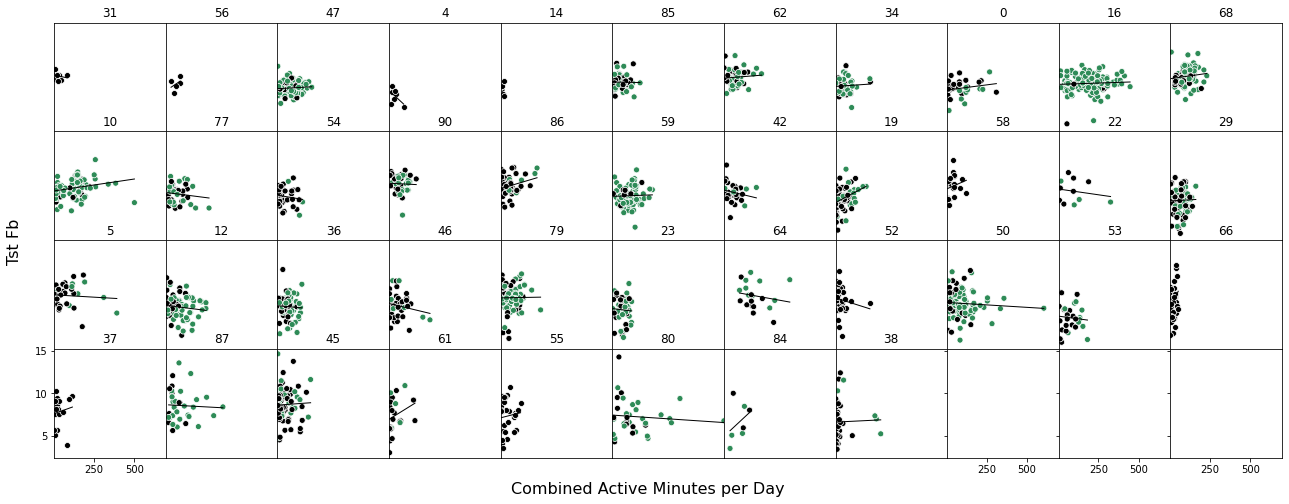

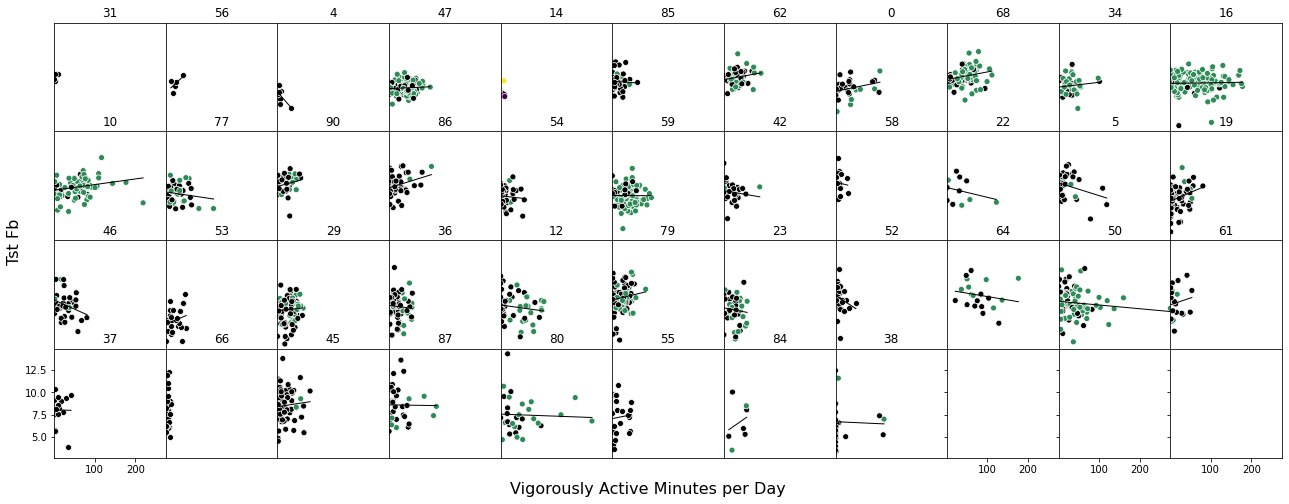

In [21]:
fitbit_processor.plot_indvidual_responses(activity_weekly_complete, show=True)

In [22]:
def get_restrcited_activity_df(df, activity_level, sleep_metric, order=1, id_col="redcap", min_points=3):
    """
    Removes participants from dataframe and orders according to a given column
    """
    df_cleaned = pd.DataFrame()
    for pt in df[id_col].unique():
        df_by_pt = df[df[id_col] == pt]
        if len(df_by_pt) >= 7:
            df_by_pt_no_zeros = df_by_pt[df_by_pt[f"{activity_level}_weekly"] > 0]
            if len(df_by_pt_no_zeros) >= min_points:
                met = df_by_pt_no_zeros[df_by_pt_no_zeros[f"{activity_level}_met"] == True]
                unmet = df_by_pt_no_zeros[df_by_pt_no_zeros[f"{activity_level}_met"] == False]
                if len(met) > 0 and len(unmet) > 0:
                    df_by_pt_no_zeros["n"] = len(df_by_pt_no_zeros)
                    df_by_pt_no_zeros["slope"] = np.polyfit(df_by_pt_no_zeros[f"{activity_level}_weekly"],df_by_pt_no_zeros[sleep_metric],deg=order)[0]
                    df_by_pt_no_zeros["r"] = abs(np.polyfit(df_by_pt_no_zeros[f"{activity_level}_weekly"],df_by_pt_no_zeros[sleep_metric],deg=order,full=True)[1][0])
                    df_cleaned = df_cleaned.append(df_by_pt_no_zeros)
                
    return df_cleaned.sort_values("n",ascending=True)

In [23]:
def plot_met_vs_unmet_scatter(df, levels=["combined","vigorously"], sleep_metrics=["rem_percent","wake_percent","nrem_percent","rem2nrem_percent","efficiency","tst_fb"], save_dir="../reports/figures/fitbit_summary", save=False):
    for sleep_metric in sleep_metrics:
        for level in levels:
            df_to_plot = get_restrcited_activity_df(activity_weekly_complete,level,sleep_metric)
            fig, axes = plt.subplots(4,8,figsize=(16,8),sharey=True,sharex=True,gridspec_kw={"wspace":0,"hspace":0})
            for pt, ax in zip(df_to_plot["redcap"].unique(),axes.flat):
                df_to_plot_by_pt = df_to_plot[df_to_plot["redcap"] == pt]
                met = df_to_plot_by_pt[df_to_plot_by_pt[f"{level}_met"] == True]
                unmet = df_to_plot_by_pt[df_to_plot_by_pt[f"{level}_met"] == False]
                sns.scatterplot(x=f"{level}_weekly",y=sleep_metric,data=df_to_plot_by_pt,hue=f"{level}_met",palette=["black","seagreen"],ax=ax,legend=False)
                sns.regplot(x=f"{level}_weekly",y=sleep_metric,data=met,ci=None,truncate=True,order=1,
                            scatter=False,line_kws={"linewidth":1,"color":"seagreen"},ax=ax)
                sns.regplot(x=f"{level}_weekly",y=sleep_metric,data=unmet,ci=None,truncate=True,order=1,
                            scatter=False,line_kws={"linewidth":1,"color":"black"},ax=ax)
                ax.set_xlabel("")
                ax.set_ylabel("")
                ax.set_title(int(pt),y=1.0)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                for loc in ["top","bottom","left","right"]:
                    ax.spines[loc].set_visible(False)

            fig.text(0.1,0.5,sleep_metric.replace("_"," ").replace("2",":").title(), ha='center', va='center', rotation='vertical',size=16)
            fig.text(0.5, 0.07, f"{level.title()} Active Minutes per Day", ha='center', va='center',size=16)

            axes[3,0].get_xaxis().set_visible(True)
            axes[3,0].get_yaxis().set_visible(True)
            
            if save:
                plt.savefig(f"{save_dir}/{level}-{sleep_metric}-individual_scatter.png",bbox_inches="tight")
            plt.show()
            plt.close()

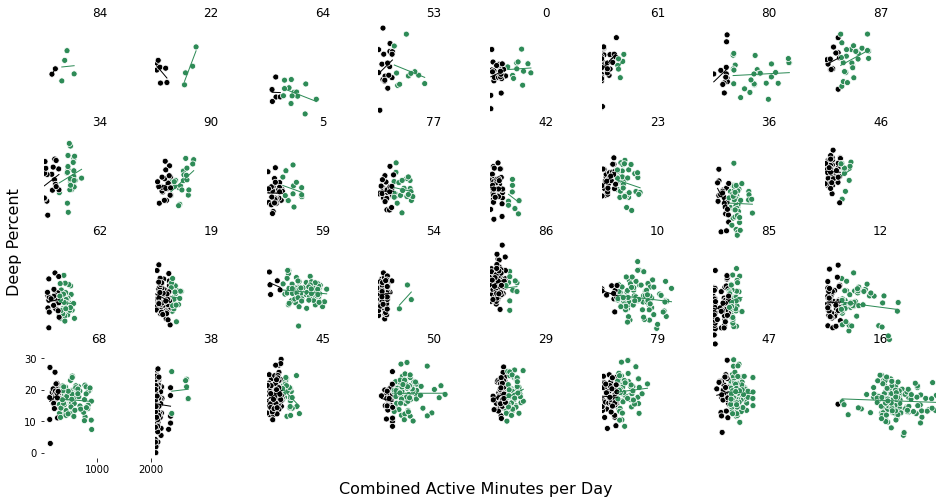

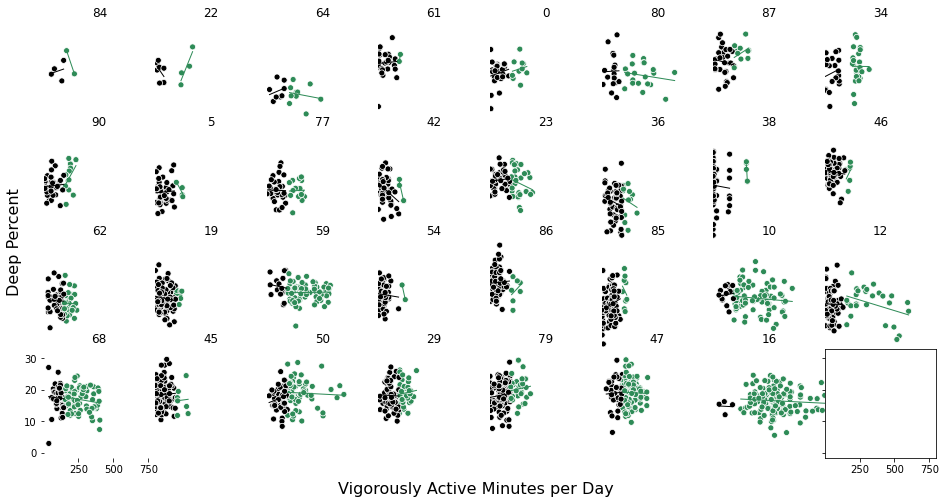

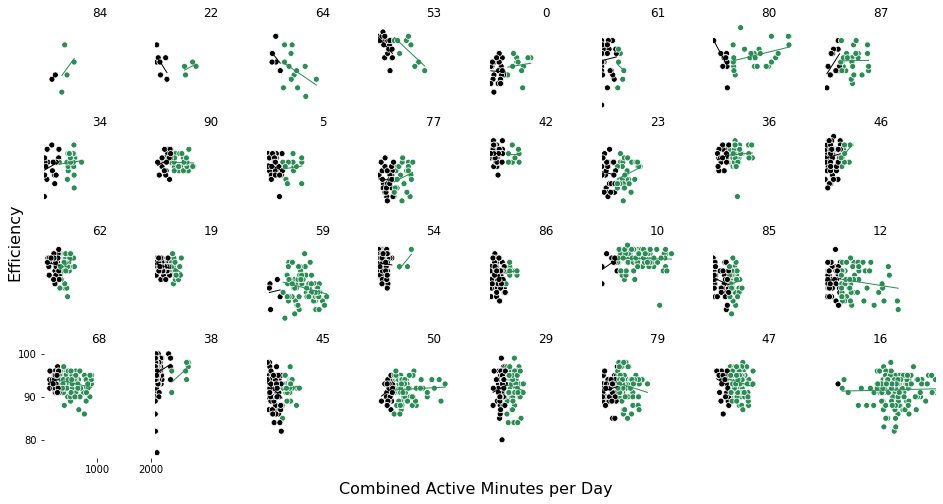

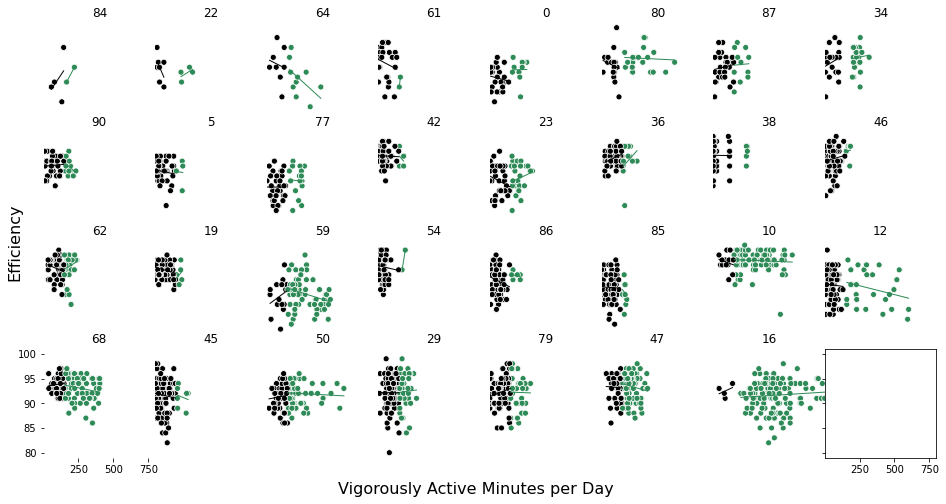

In [24]:
plot_met_vs_unmet_scatter(activity_weekly_complete, sleep_metrics=["deep_percent","efficiency"], save=False) 